In [8]:
%matplotlib inline
from experiment import *
import numpy as np

In [2]:
label_url

'/Users/chiyuan/Documents/home/Train/CameraSeg'

In [3]:
label_url

'/Users/chiyuan/Documents/home/Train/CameraSeg'

In [24]:
classes = np.array([0, 1, 2])
pix_counts = np.zeros(3,)
denom = np.zeros(3,)
import os
import cv2
for f in os.listdir(label_url):
    yimg = cv2.imread(os.path.join(label_url, f))
    label_ch = yimg[:,:,2]
    veh_pixels = (label_ch == 10).nonzero()
    hood_indices = (veh_pixels[0] >= 496).nonzero()[0]
    hood_pixels = (veh_pixels[0][hood_indices], \
                   veh_pixels[1][hood_indices])
    
    label_ch[hood_pixels] = 0
    label_ch[label_ch == 6] = 7
    label_ch[(label_ch != 10) & (label_ch != 7)] = 0
                       
                       
    vals, counts =  np.unique(label_ch, return_counts=True)
    #print(vals, counts)
    if 10 not in vals:
        counts = np.append(counts, [10])
    pix_counts += counts
    
    b = counts.astype('bool')
    denom += b * label_ch.size
    
freq = pix_counts/denom
print("final stats:", np.median(freq)/freq)

final stats: [  0.25325792   1.          14.259816  ]


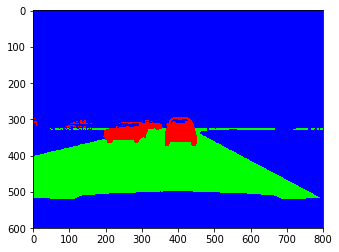

In [9]:
import matplotlib.pyplot as plt
plt.imshow(process_label(cv2.imread(os.path.join(label_url, os.listdir(label_url)[0]))))

In [12]:
d = process_label(cv2.imread(os.path.join(label_url, os.listdir(label_url)[0])))
d[d == 2].any()

False

In [23]:
a = np.eye(7)
np.median(a)

0.0